This notebook is only used to show the results of the MLFlow runs

In [26]:
import os

import pandas as pd
from matplotlib import pyplot as plt

In [29]:
metrics_path = '../results/metrics/'
TRTS_results = pd.read_csv(f'{metrics_path}/TRTS_results.csv')
TRTS_means = pd.read_csv(f'{metrics_path}/TRTS_means.csv')
PS_results = pd.read_csv(f'{metrics_path}/PS_results.csv')
PS_means = pd.read_csv(f'{metrics_path}/PS_means.csv')
DS_results = pd.read_csv(f'{metrics_path}/DS_results.csv')
DS_means = pd.read_csv(f'{metrics_path}/DS_means.csv')

## Train on Real Test on Synthetic

In [30]:
TRTS_means = TRTS_means.round({'f1_score': 2, 'accuracy': 2, 'recall': 2, 'precision': 2})
TRTS_means.sort_values(by='f1_score', ascending=False)

,key,f1_score,accuracy,recall,precision,model,params
0,carla_fixed,0.53,0.53,0.53,0.53,XGBClassifier,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
1,carla_llm,0.52,0.52,0.52,0.53,XGBClassifier,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti..."
2,sumo_llm,0.48,0.52,0.52,0.51,RFClassifier,"{'max_depth': 10, 'n_estimators': 50}"
3,sumo_fixed,0.47,0.50,0.50,0.50,XGBClassifier,"{'learning_rate': 0.001, 'max_depth': 10, 'n_e..."


Clearly, the models trained on synthetic data can't learn anything from the real-world data, suggesting that the data has low realism and will probably not be useful in real world scenarios.

## Discriminative Score

In [31]:
DS_means.sort_values(by='f1_score', ascending=False)

,key,f1_score,accuracy,recall,precision,model,params
0,sumo_fixed,1.0,1.0,1.0,1.0,RFClassifier,{'default'}
1,sumo_llm,1.0,1.0,1.0,1.0,RFClassifier,{'default'}
2,carla_fixed,1.0,1.0,1.0,1.0,RFClassifier,{'default'}
3,carla_llm,1.0,1.0,1.0,1.0,RFClassifier,{'default'}


This shows that the models can clearly distinguish synthetic and real data, reinforcing their low realism

## Predictive Score

In [32]:
PS_means = PS_means.round({'f1_score': 2, 'accuracy': 2, 'recall': 2, 'precision': 2})
PS_means.sort_values(by='f1_score', ascending=False)

,key,f1_score,accuracy,recall,precision,model,params
0,uah,0.75,0.76,0.76,0.78,SVC,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}"
1,sumo_uah_fixed_100,0.72,0.72,0.72,0.73,SVC,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}"
2,sumo_uah_llm_100,0.71,0.71,0.71,0.72,SVC,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}"
3,sumo_uah_fixed_20,0.71,0.71,0.71,0.72,SVC,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}"
4,sumo_uah_llm_200,0.71,0.71,0.71,0.73,SVC,"{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}"
5,sumo_uah_llm_20,0.70,0.70,0.70,0.70,SVC,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}"
6,sumo_uah_fixed_200,0.70,0.71,0.71,0.74,SVC,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}"
7,carla_uah_fixed_200,0.66,0.67,0.67,0.68,XGBClassifier,"{'colsample_bytree': 1.0, 'learning_rate': 0.1..."
8,carla_uah_fixed_100,0.65,0.66,0.66,0.66,XGBClassifier,"{'colsample_bytree': 0.7, 'learning_rate': 0.1..."
9,carla_uah_fixed_20,0.64,0.64,0.64,0.64,RFClassifier,"{'max_depth': 20, 'n_estimators': 20}"


This shows that the addition of synthetic data was not able to improve model performance. It also shows that CARLA data degrades performance substancially. Results suggest low utility and coherence of the data.

## tSNE Visualization

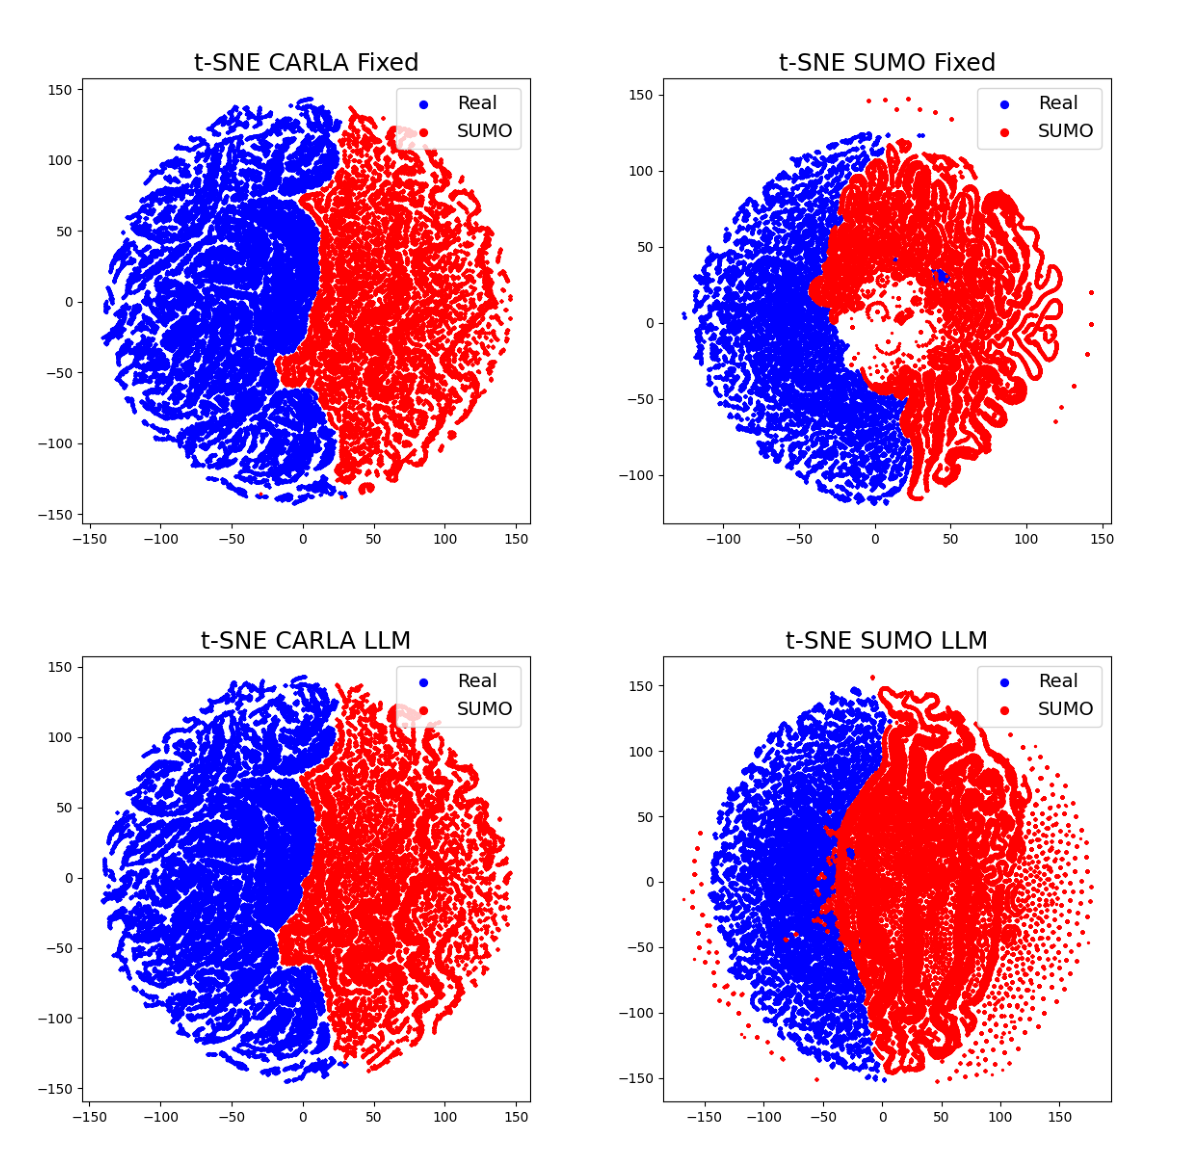

In [44]:
images_path = '../results/figures/tsne/'
files = [f for f in os.listdir(images_path) if f.endswith('.png')]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i, f in enumerate(files):
    img = plt.imread(f'{images_path}/{f}')
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f'{images_path}/tsne_results.png', bbox_inches='tight', dpi=300)

Here we can see that the synthetic data is easily distinguishable from the real data, as expected from the results above.